In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from IPython.display import display
import matplotlib as mpl
import polars as pl
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-01T19:34:20.325229+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.13.2
polars    : 1.9.0
matplotlib: 3.10.0
teeplot   : 1.4.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-01-cpp-bench-memory-native-tilted"
)
teeplot_subdir


'2025-06-30-cpp-bench-memory-tilted'

## Prep Data


In [5]:
algo_names = {
    "dstream.circular_algo": "simple ringbuf",
    "control_throwaway_algo": "no-operation",
    "dstream.tilted_algo": "extended ringbuf",
    "dstream_tilted_algo": "extended ringbuf LUT",
    "doubling_tilted_algo": "naive doubling",
    "zhao_tilted_algo": "pyrimidal bucket",
    "zhao_tilted_full_algo": "saturating bucket",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/cbqpx/download"),
    ],
)
print("\n".join(df["algo_name"].unique().to_list()))
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
        pl.col("num_items") == 1_000_000,
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        ),
        num_retained=(
            pl.when(pl.col("algo_name") == "dstream_tilted_algo")
            .then(pl.col("num_sites"))
            .when(pl.col("algo_name") == "doubling_tilted_algo")
            .then(pl.col("num_sites") * 0.75)
            .when(pl.col("algo_name") == "zhao_tilted_algo")
            .then(19)
            .when(pl.col("algo_name") == "zhao_tilted_full_algo")
            .then(pl.col("num_sites"))
            .otherwise(pl.col("num_sites"))
        )
    )
    .with_columns(
        (pl.col("memory_bytes") / pl.col("num_retained")).alias("bytes per item"),
    )
    .with_columns(
        (8 * pl.col("memory_bytes") / pl.col("num_retained")).alias("bits per item"),
    )
    .with_columns(
        memory_bits=pl.col("memory_bytes") * 8,
        item_bits=(
            pl.col("data_type")
            .map_elements(
                {
                    "bit": 1, "byte": 8, "word": 16, "double word": 32
                }.get,
                return_dtype=pl.Int32,
            )
        ),
    )
    .with_columns(
        overhead_bits=(
            pl.col("memory_bits") - pl.col("item_bits") * pl.col("num_retained")
        ),
    )
    .with_columns(overhead_bytes=pl.col("overhead_bits") // 8)
    .with_columns(
        (
            100 * pl.col("item_bits") / pl.col("bits per item")
        ).alias("Memory Efficiency (%)"),
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


dstream.circular_algo
dstream.stretched_algo
dstream_stretched_algo
control_throwaway_algo
zhao_tilted_full_algo
dstream.compressing_algo
doubling_tilted_algo
doubling_steady_algo
zhao_tilted_algo
zhao_steady_algo
dstream_tilted_algo
dstream.tilted_algo
dstream.steady_algo


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""1120""","""1120""","""1120""",1120.0,1120.0,1120.0,1120.0,1120.0,"""1120""",1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,"""1120"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,2106.571429,1e6,1360.0,4.5,5.660586,null,1119.857143,2.280555,18.244439,16852.571429,14.25,894.607143,111.803571,80.853022,null
"""std""",null,null,null,3978.521282,0.0,1620.679234,2.873564,23.588329,null,1517.611823,1.710403,13.683223,31828.170259,11.545844,3581.646965,447.70889,25.453662,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,1e6,64.0,0.0,0.080037,"""extended ringbuf""",19.0,0.125977,1.0078125,96.0,1.0,32.0,4.0,4.398148,"""bit"""
"""25%""",null,null,null,119.0,1e6,256.0,2.0,0.196042,null,64.0,1.003906,8.03125,952.0,8.0,32.0,4.0,70.588235,null
"""50%""",null,null,null,320.0,1e6,1024.0,5.0,1.133214,null,256.0,2.015625,16.125,2560.0,16.0,32.0,4.0,96.969697,null
"""75%""",null,null,null,2052.0,1e6,1024.0,7.0,2.020015,null,1024.0,4.000977,32.007812,16416.0,16.0,413.0,51.0,99.224806,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,9.0,204.034583,"""simple ringbuf""",4096.0,6.263158,50.105263,132096.0,32.0,32800.0,4100.0,99.975592,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,0,0.080503,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,1,0.080506,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,2,0.080556,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,3,0.080556,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,4,0.080506,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,3.017475,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,3.017482,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,3.017487,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,3.017428,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,3.017484,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""


In [6]:
assert (df.group_by(
    ["num_items", "num_sites", "algorithm", "data type"],
).agg(
    pl.col("memory_bytes").n_unique(),
)["memory_bytes"] == 1).all()


In [7]:
hue_order = [
    "extended ringbuf",
    "saturating bucket",
    "pyrimidal bucket",
    # "extended ringbuf LUT",
    # "simple ringbuf",
    "naive doubling",
]


In [8]:
palette = sns.color_palette("muted")
palette_assignments = {
    "extended ringbuf": palette[0],
    "extended ringbuf LUT": palette[1],
    "saturating bucket": palette[2],
    "pyrimidal bucket": palette[3],
    "simple ringbuf": palette[4],
    "naive doubling": palette[5],
    "no-operation": palette[6],
}


## Plot


## Memory Per Item


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


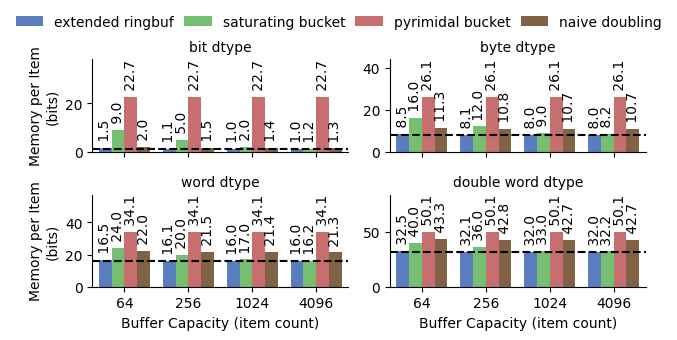

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


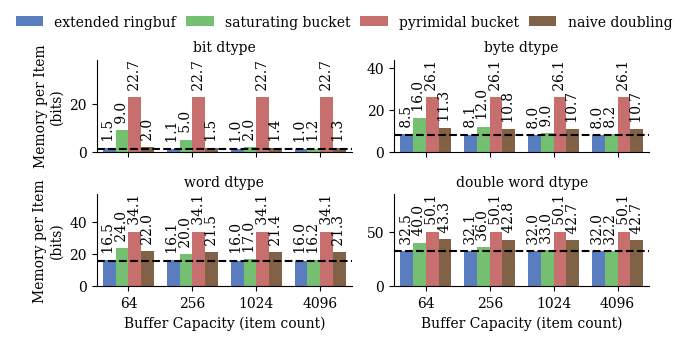

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


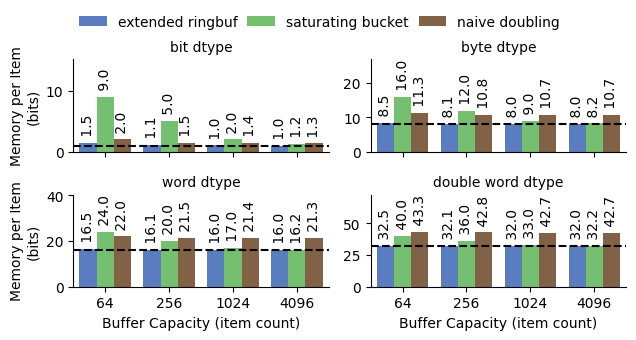

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


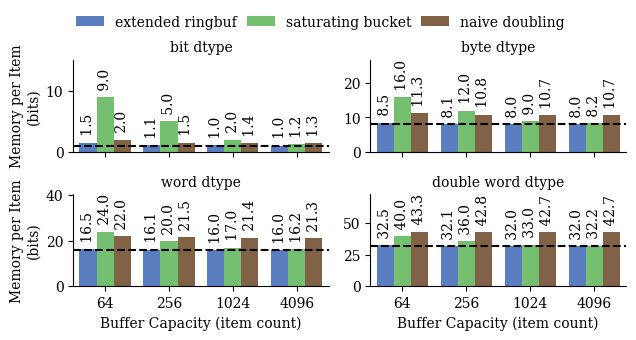

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


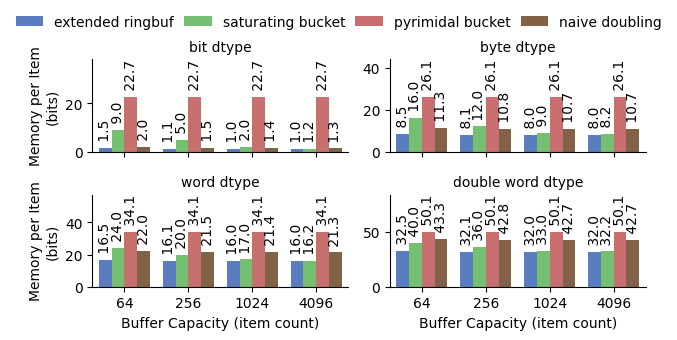

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


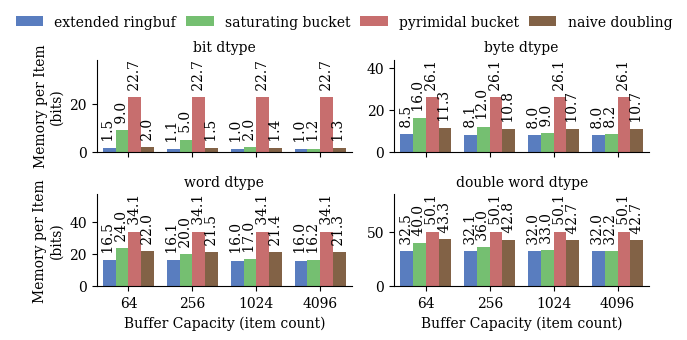

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


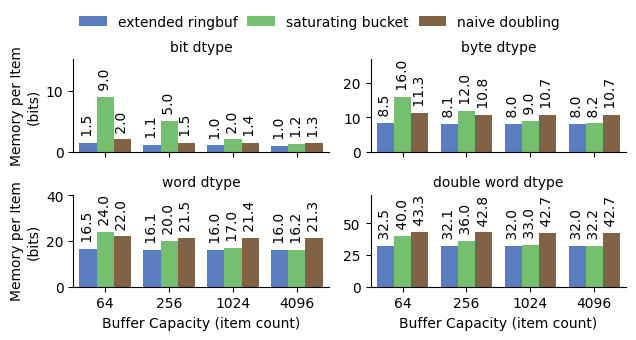

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


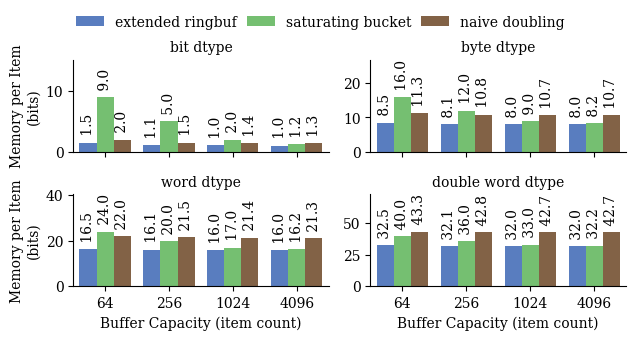

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


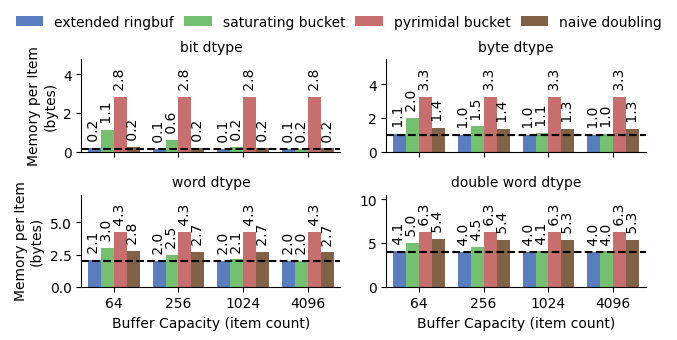

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


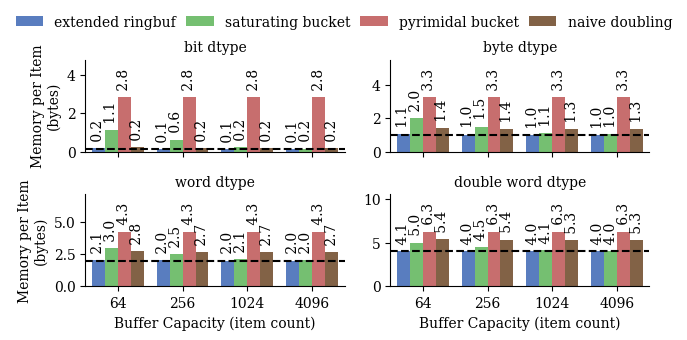

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


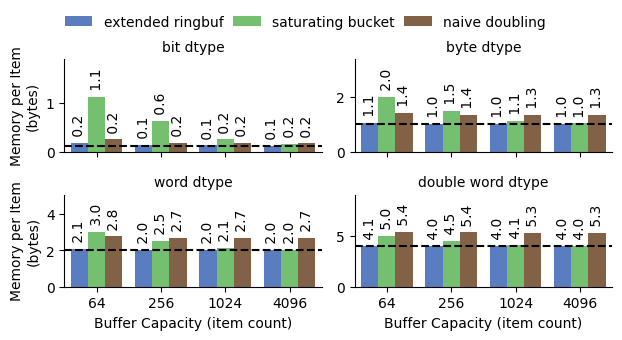

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


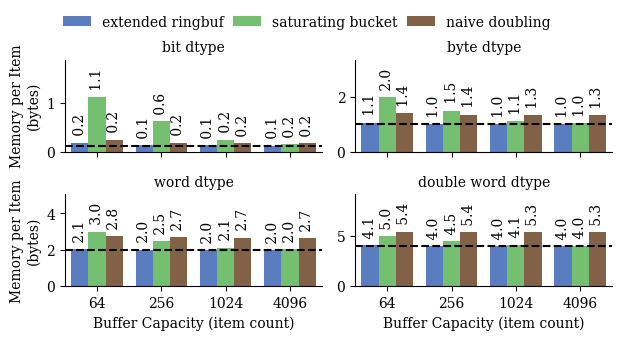

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


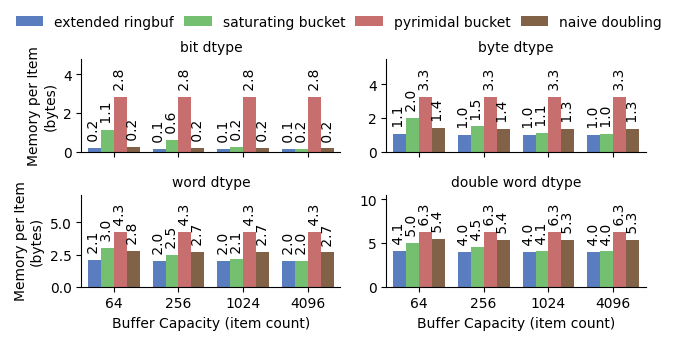

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


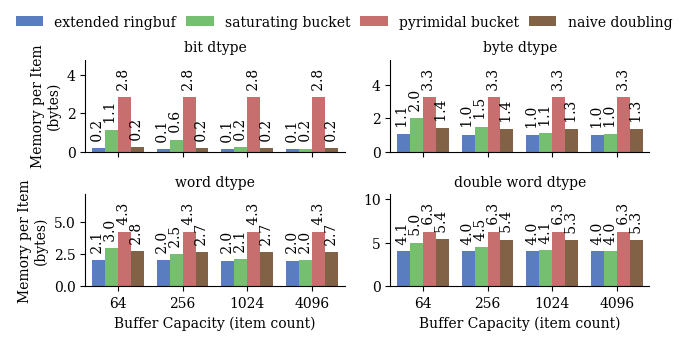

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


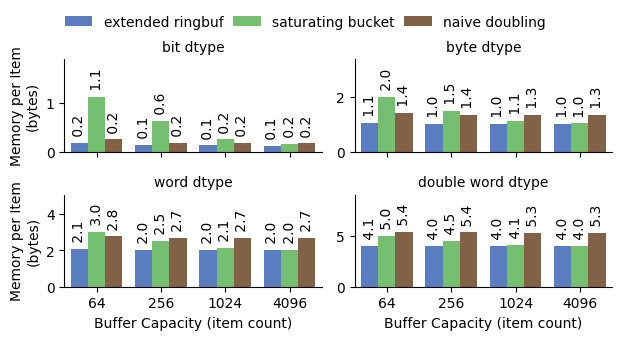

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


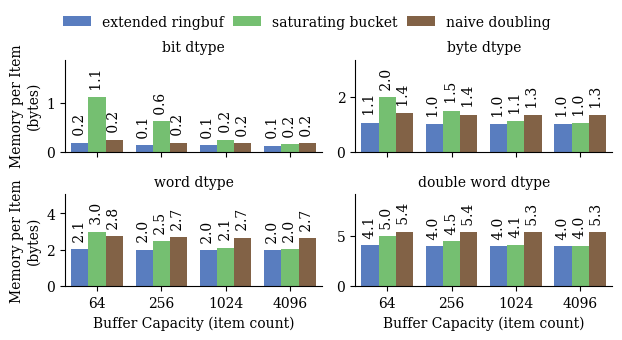

In [9]:
for unit, mark, excl, rc in it.product(
    ["bits", "bytes"],
    [True, False],
    [[], ["pyrimidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y=f"{unit} per item",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels(f"Memory per Item\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.6)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.1f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx]
                    ax.axhline(
                        bits * unit_scale,
                        color="k",
                        linestyle="--",
                    )


## Memory Efficiency


/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


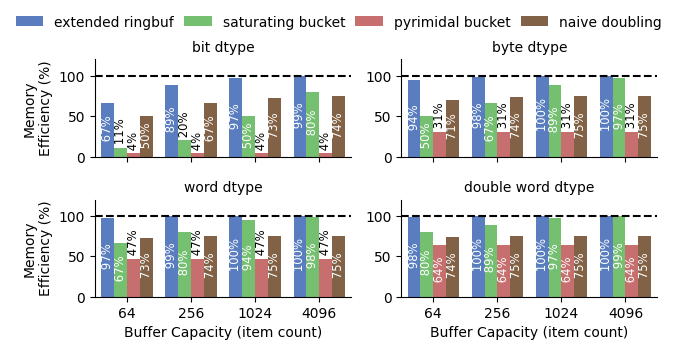

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


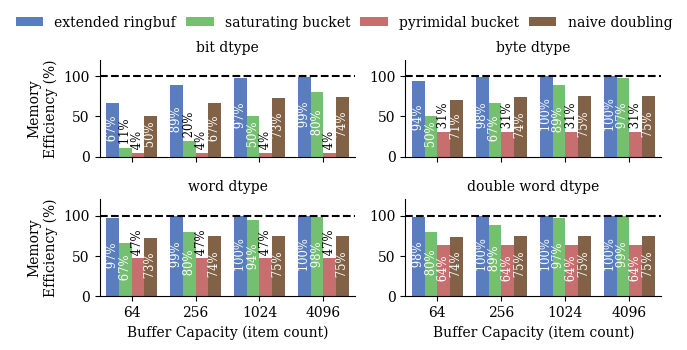

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


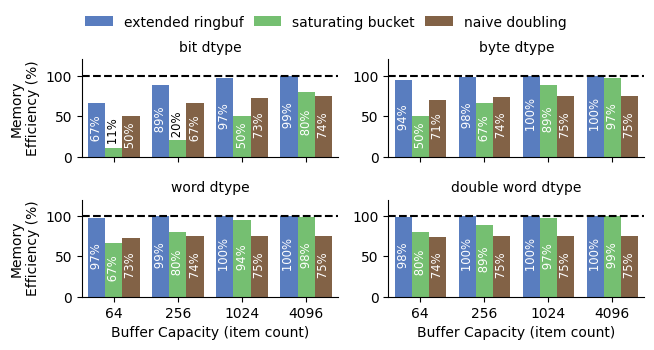

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


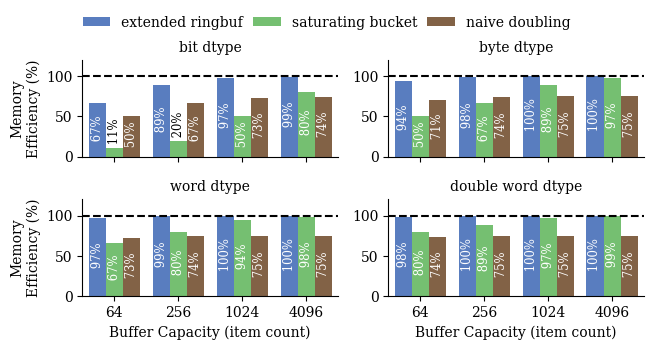

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


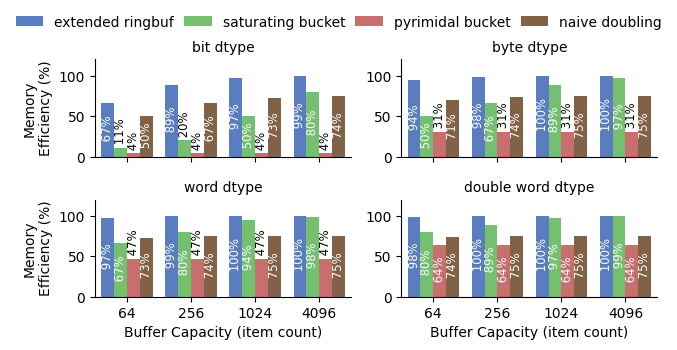

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


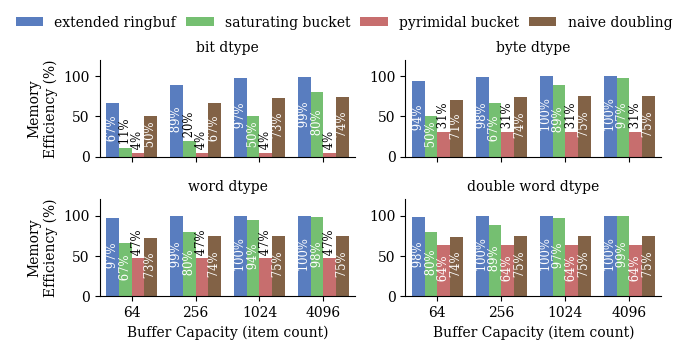

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


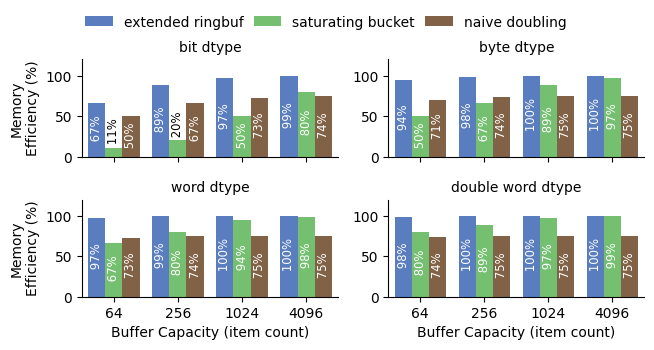

/tmp/ipykernel_11313/662603494.py:60: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  color=["white", "black"][shrink],
/tmp/ipykernel_11313/662603494.py:63: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_type=["center", "edge"][shrink],
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


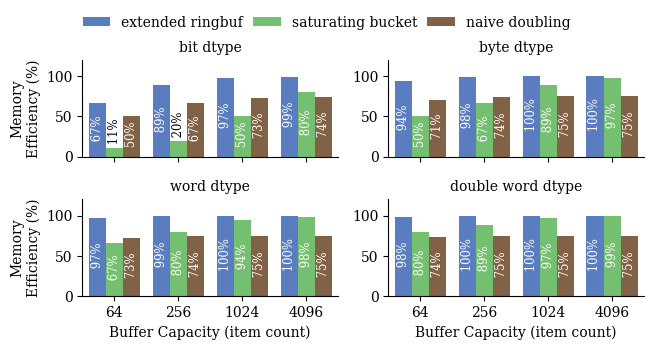

In [10]:
for mark, excl, rc in it.product(
    [True, False],
    [[], ["pyrimidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y="Memory Efficiency (%)",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.65,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels("Memory\nEfficiency (%)")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            from matplotlib import container as mpl_container
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, 120)
                for container in ax.containers:
                    for bar in container:
                        shrink = bar.get_height() < 50
                        ax.bar_label(
                            mpl_container.BarContainer(
                                [bar],
                                datavalues=[bar.get_height()],
                                orientation="vertical",
                            ),
                            color=["white", "black"][shrink],
                            fmt=" %.0f%%",
                            fontsize="small",
                            label_type=["center", "edge"][shrink],
                            rotation=90,
                        )
                if mark:
                    ax.axhline(
                        100,
                        color="k",
                        linestyle="--",
                    )


## Memory Footprint


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


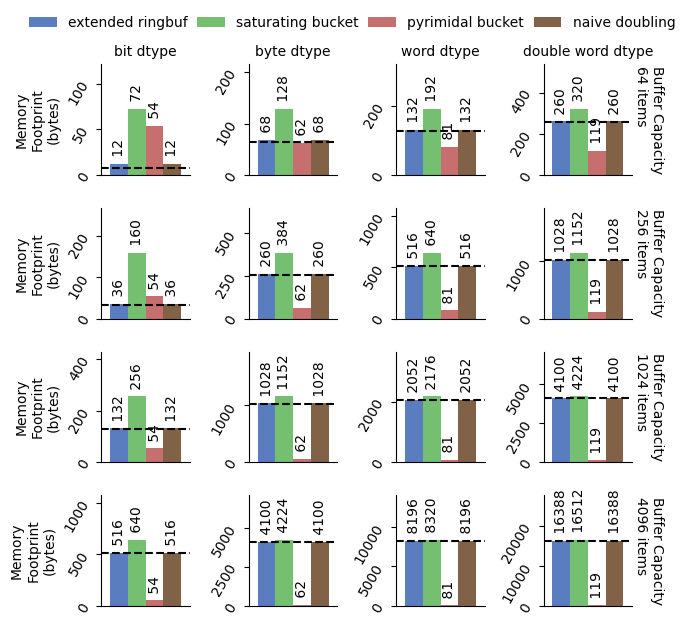

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


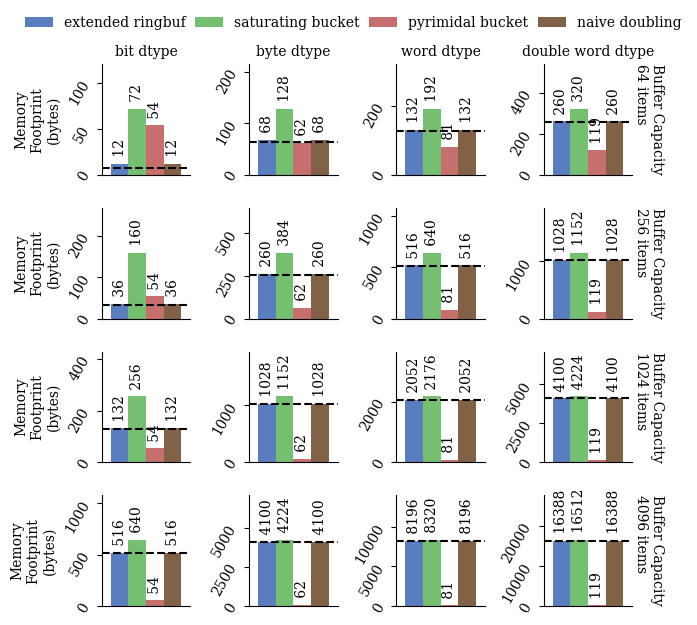

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


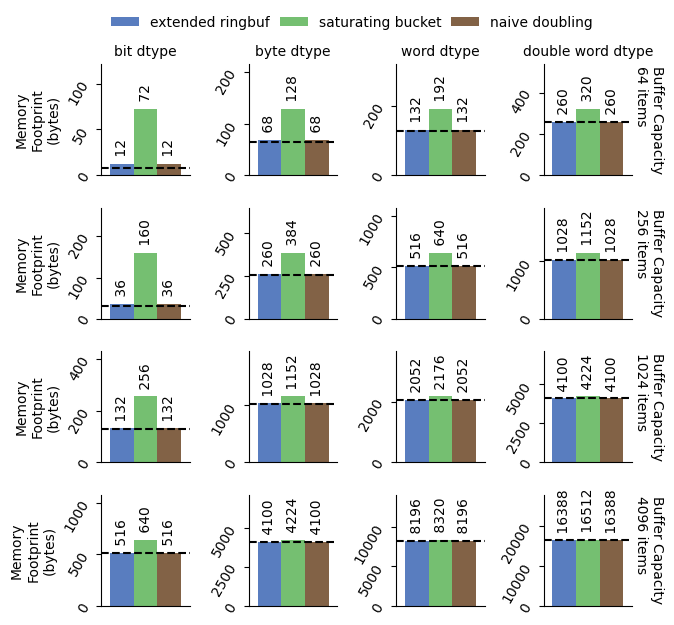

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


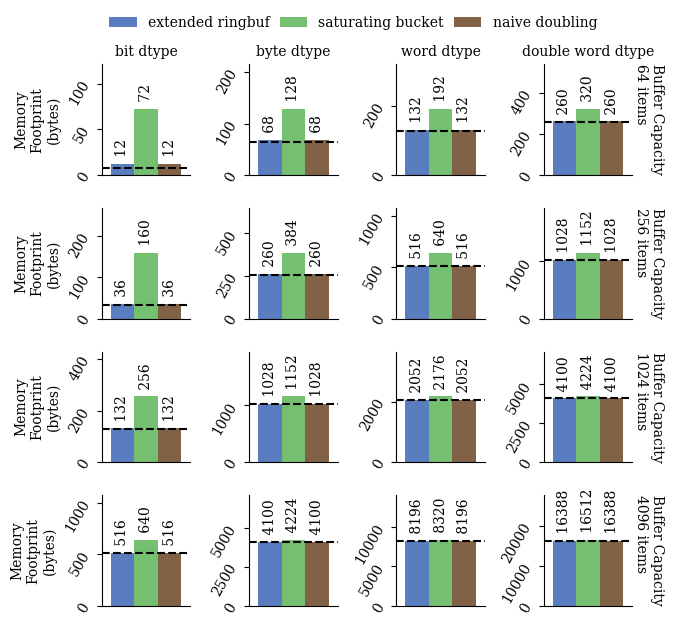

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


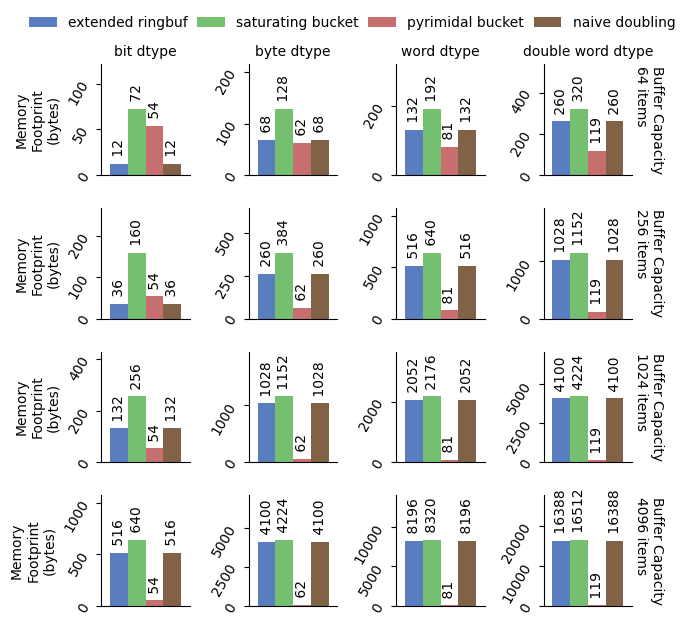

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


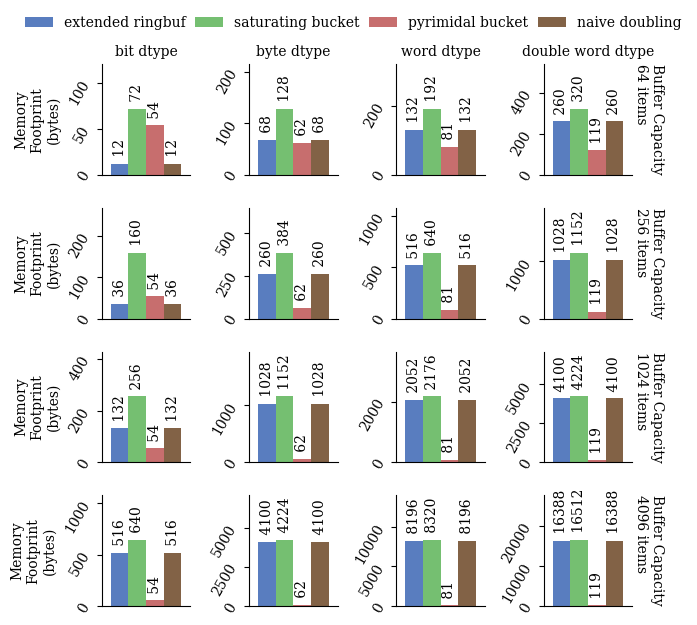

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


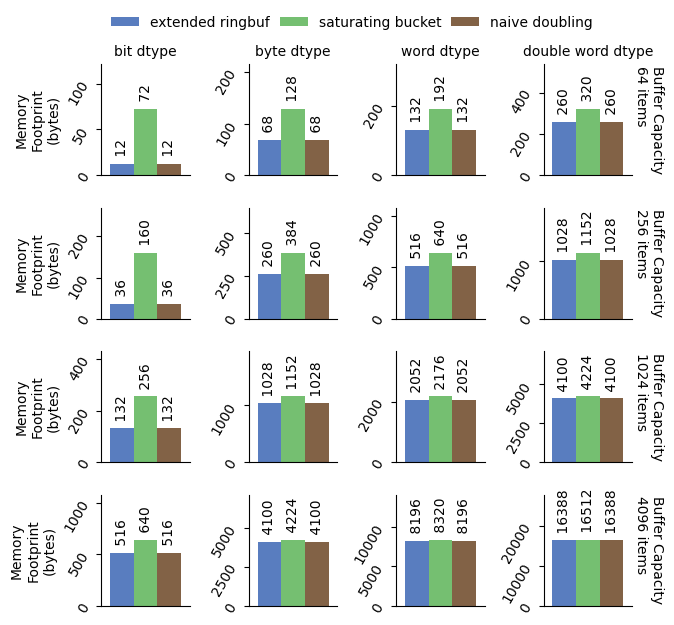

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


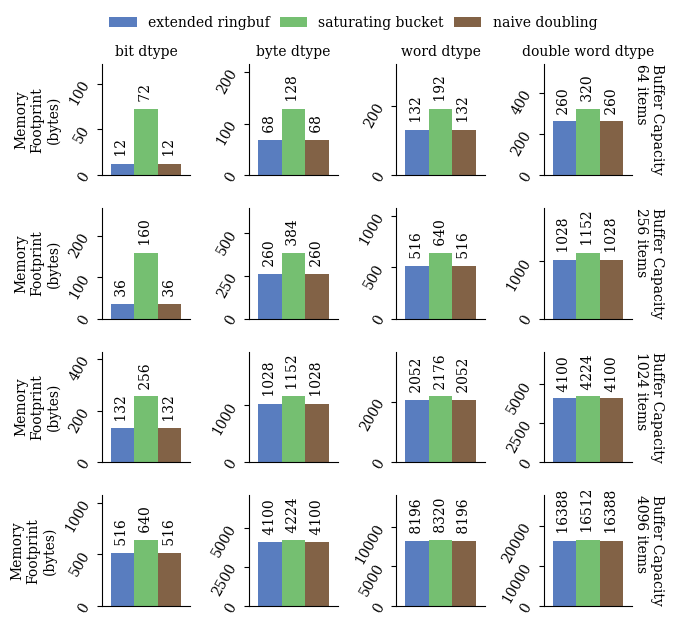

In [11]:
for unit, mark, excl, rc in it.product(
    ["bytes"],
    [True, False],
    [[], ["pyrimidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            y=f"memory_{unit}",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            row="num_sites",
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=1.2,
            height=1.5,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None), xticks=[])
            g.set_titles(
                col_template="{col_name} dtype",
                row_template="Buffer Capacity\n{row_name} items",
            )
            g.set_ylabels(f"Memory\nFootprint\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.98),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.6)
                ax.tick_params(axis="y", labelrotation=60)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.0f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx % 4]
                    num_sites = [64, 256, 1024, 4096][idx // 4]
                    ax.axhline(
                        bits * unit_scale * num_sites,
                        color="k",
                        linestyle="--",
                    )
            g.tight_layout()


## Memory Overhead


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


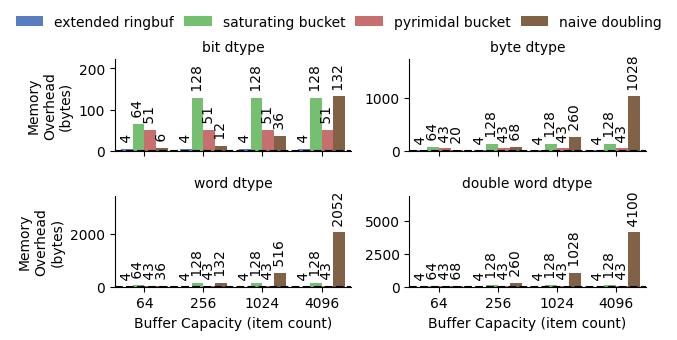

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


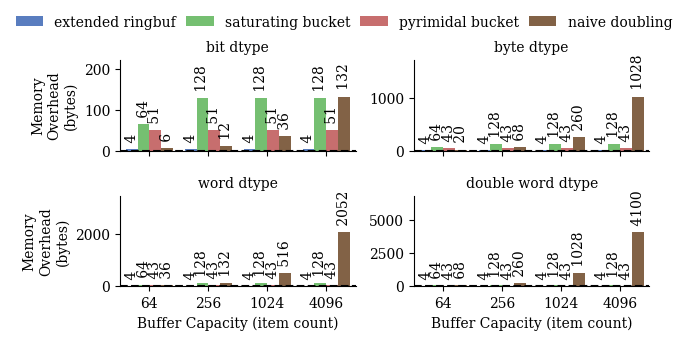

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


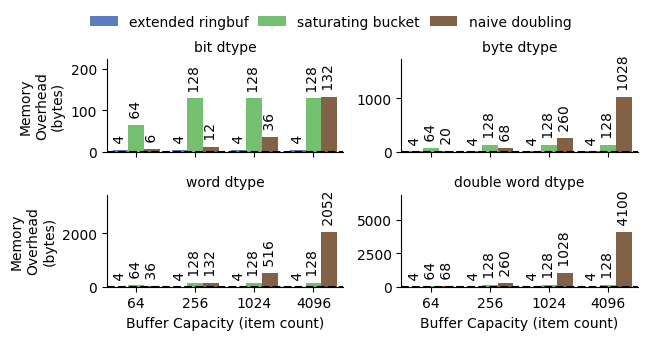

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


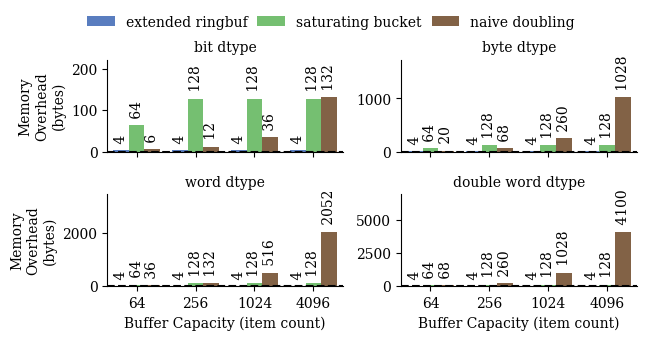

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


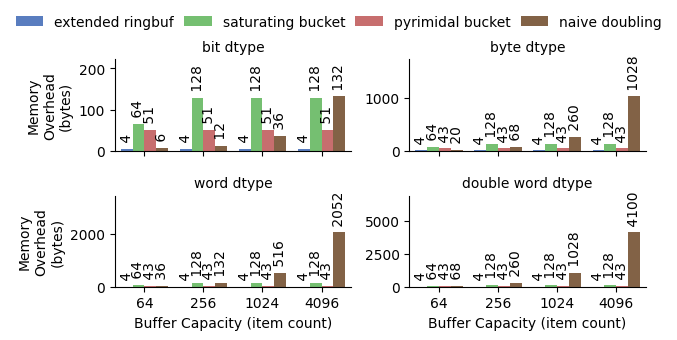

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


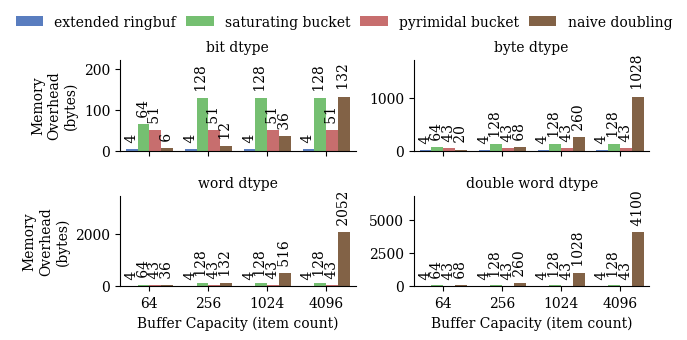

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


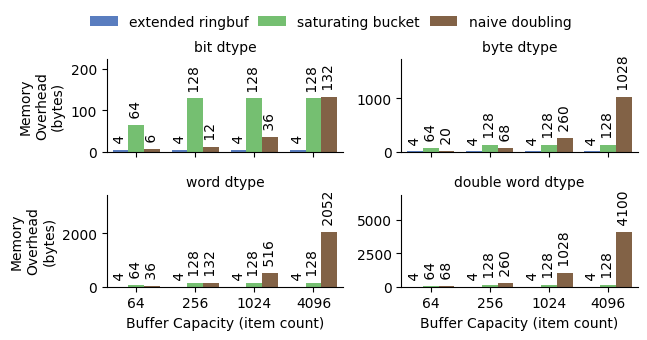

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyrimidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


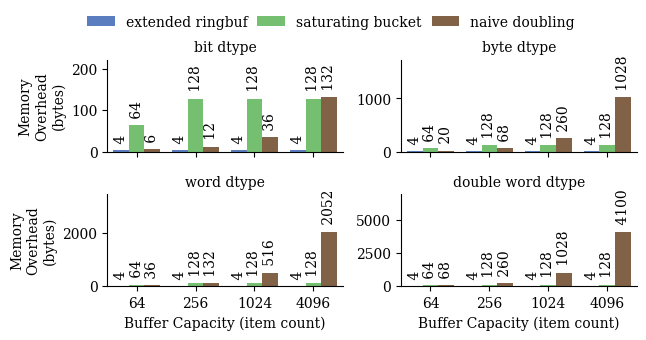

In [12]:
for unit, mark, excl, rc in it.product(
    ["bytes"],
    [True, False],
    [[], ["pyrimidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y=f"overhead_{unit}",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=("pi", 100),
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels(f"Memory\nOverhead\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.6)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.0f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx]
                    ax.axhline(
                        bits * unit_scale,
                        color="k",
                        linestyle="--",
                    )
